# Import Library

In [ ]:
from google.colab import drive
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

from keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics

## GDrive Acces

In [39]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Make variabel to define path of directory TRAIN, and VALIDATION



In [ ]:
clean_dir ='/content/drive/MyDrive/ML Team/dataset_clean'
TRAIN_dir = os.path.join(clean_dir, 'train')
VAL_dir = os.path.join(clean_dir, 'val')

In [ ]:
waste_list = os.listdir(TRAIN_dir)
num_of_waste = len(waste_list)
print('Total types of waste:', num_of_waste)

Total types of waste: 10


In [ ]:
def count_images(data_path):
    index = 1
    total_images = 0
    print('====Total of Train Datasets for Each Class===')
    for image_class in waste_list:
        class_path = os.path.join(data_path, image_class)
        num_images = len(os.listdir(class_path))
        print('{:2}. {:16} : {}'.format(index, image_class, num_images))
        index += 1
        total_images += num_images
    print('\nTotal images:', total_images)
count_images(TRAIN_dir)


====Total of Train Datasets for Each Class===
 1. kertas           : 402
 2. galon            : 400
 3. kardus           : 415
 4. botol_plastik    : 400
 5. kaca             : 400
 6. bungkus_plastik  : 400
 7. cup_gelas        : 409
 8. sampah_organik   : 413
 9. ban              : 400
10. kaleng           : 403

Total images: 4042


In [38]:
def count_images(data_path):
    index = 1
    total_images = 0
    print('====Total of Val Datasets for Each Class===')
    for image_class in waste_list:
        class_path = os.path.join(data_path, image_class)
        num_images = len(os.listdir(class_path))
        print('{:2}. {:16} : {}'.format(index, image_class, num_images))
        index += 1
        total_images += num_images
    print('\nTotal images:', total_images)
count_images(VAL_dir)


====Total of Val Datasets for Each Class===
 1. kertas           : 101
 2. galon            : 100
 3. kardus           : 104
 4. botol_plastik    : 100
 5. kaca             : 100
 6. bungkus_plastik  : 100
 7. cup_gelas        : 103
 8. sampah_organik   : 104
 9. ban              : 100
10. kaleng           : 101

Total images: 1013


# Image Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, # converts pixels in range [0.255] to range [0.1].
    horizontal_flip = True, # to flip the position of an image horizontally
    vertical_flip = False, # to flip the position of an image vertically
    rotation_range=30, # randomly rotate images in the range
    brightness_range=[0.5,1.0],
    zoom_range = 0.1,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

val_datagen =ImageDataGenerator( rescale=1./255 )

In [ ]:
BATCH_SIZE = 64
train_generator = train_datagen.flow_from_directory(
    TRAIN_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode='rgb'

)

validation_generator = val_datagen.flow_from_directory(
    VAL_dir,
    target_size = (224,224),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    color_mode='rgb'

)


nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Found 4042 images belonging to 10 classes.
Found 1013 images belonging to 10 classes.
Classes: ['ban', 'botol_plastik', 'bungkus_plastik', 'cup_gelas', 'galon', 'kaca', 'kaleng', 'kardus', 'kertas', 'sampah_organik']


In [ ]:
train_generator.class_indices

{'ban': 0,
 'botol_plastik': 1,
 'bungkus_plastik': 2,
 'cup_gelas': 3,
 'galon': 4,
 'kaca': 5,
 'kaleng': 6,
 'kardus': 7,
 'kertas': 8,
 'sampah_organik': 9}

## Displays a sample image of the generator train

In [ ]:
def show_image_samples(gen):
    train_dict=train_generator.class_indices
    classes=list(train_dict.keys())
    images,labels=next(gen) # get a sample batch from the generator
    plt.figure(figsize=(30, 30))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

In [ ]:
show_image_samples(train_generator)

Output hidden; open in https://colab.research.google.com to view.

# Build the model

## DenseNet121




In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model.layers[:125]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation="softmax")(x)

# Pastikan untuk membuat model dengan base_model.input sebagai input
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001),
loss='categorical_crossentropy',
metrics = ['accuracy'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

# Fit and Train the Model

In [17]:
history = model.fit(train_generator,
               epochs=100,
               validation_data=validation_generator,
               callbacks=[callback])

Epoch 1/100
64/64 [==============================] - 1882s 29s/step - loss: 1.9320 - accuracy: 0.3637 - val_loss: 0.8203 - val_accuracy: 0.7700
Epoch 2/100
64/64 [==============================] - 1684s 26s/step - loss: 0.8885 - accuracy: 0.7053 - val_loss: 0.2808 - val_accuracy: 0.9171
Epoch 3/100
64/64 [==============================] - 1701s 27s/step - loss: 0.5098 - accuracy: 0.8397 - val_loss: 0.1781 - val_accuracy: 0.9437
Epoch 4/100
64/64 [==============================] - 1677s 26s/step - loss: 0.3438 - accuracy: 0.8996 - val_loss: 0.1490 - val_accuracy: 0.9576
Epoch 5/100
64/64 [==============================] - 1694s 26s/step - loss: 0.2881 - accuracy: 0.9132 - val_loss: 0.1375 - val_accuracy: 0.9487
Epoch 6/100
64/64 [==============================] - 1662s 26s/step - loss: 0.2132 - accuracy: 0.9352 - val_loss: 0.1090 - val_accuracy: 0.9684
Epoch 7/100
64/64 [==============================] - 1711s 27s/step - loss: 0.1704 - accuracy: 0.9537 - val_loss: 0.1316 - val_accuracy:

#EVALUATION (ACCURACY LEVEL & MODEL LOSS)

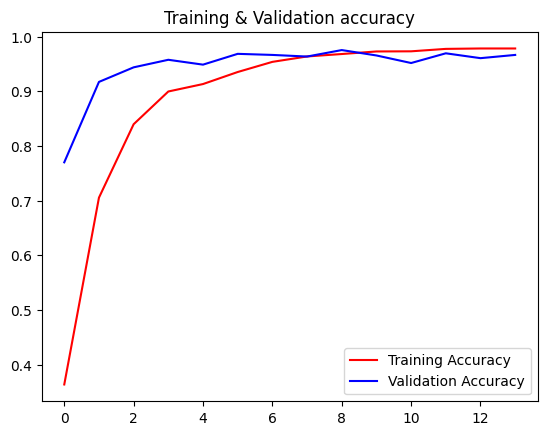

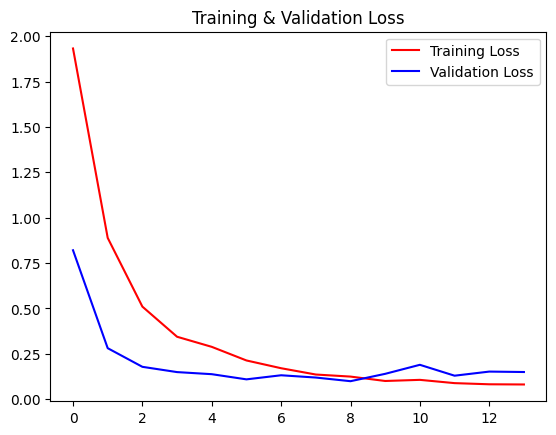

In [18]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(acc))

plt.plot(epoch, acc, 'r', label = 'Training Accuracy')
plt.plot(epoch, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Training & Validation accuracy')
plt.legend(loc = 'best')
plt.show()


plt.plot(epoch, loss, 'r', label = 'Training Loss')
plt.plot(epoch, val_loss, 'b', label = 'Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc = 'best')
plt.show()

In [19]:
# Using the validation dataset
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

<ipython-input-19-0b1386c018fa>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 0.149465411901474
Val accuracy: 0.9664363265037537


# Test the Model with image outside train and val directory

## Upload Image

In [27]:
waste_class = classes
print('\nClass of waste dataset:\n{}'.format(waste_class))


Class of waste dataset:
['ban', 'botol_plastik', 'bungkus_plastik', 'cup_gelas', 'galon', 'kaca', 'kaleng', 'kardus', 'kertas', 'sampah_organik']


In [28]:
from PIL import Image
from numpy import asarray

def preprocess_image_as_array(path, show_output):
    im = Image.open(path).convert('RGB')
    im = im.resize((224, 224))

    plt.figure(figsize=(8, 8))
    plt.imshow(im)
    plt.axis('off')

    image_as_array = np.expand_dims(asarray(im), axis=0)
    scaled_image_as_array = np.true_divide(image_as_array, 255)

    if show_output:
        print('Gambar {} selesai di proses.'.format(path))
    return scaled_image_as_array

def preprocess_and_predict(image_path, show_output=True):
    image_as_array = preprocess_image_as_array(image_path, show_output)
    pred = model.predict(image_as_array)
    sorted_ranks = np.flip(np.argsort(pred[0]))

    if show_output:
        rank = 1
        print('Prediksi Sampah:')
        for waste_rank in sorted_ranks:
            print('{:2}. {:16}: {:.3f}'.format(rank, waste_class[waste_rank], pred[0][waste_rank]))
            rank += 1
    print('')

Gambar /content/kardus_106.jpg selesai di proses.
1/1 [==============================] - 4s 4s/step
Prediksi Sampah:
 1. kardus          : 1.000
 2. kertas          : 0.000
 3. botol_plastik   : 0.000
 4. kaleng          : 0.000
 5. kaca            : 0.000
 6. bungkus_plastik : 0.000
 7. cup_gelas       : 0.000
 8. ban             : 0.000
 9. sampah_organik  : 0.000
10. galon           : 0.000



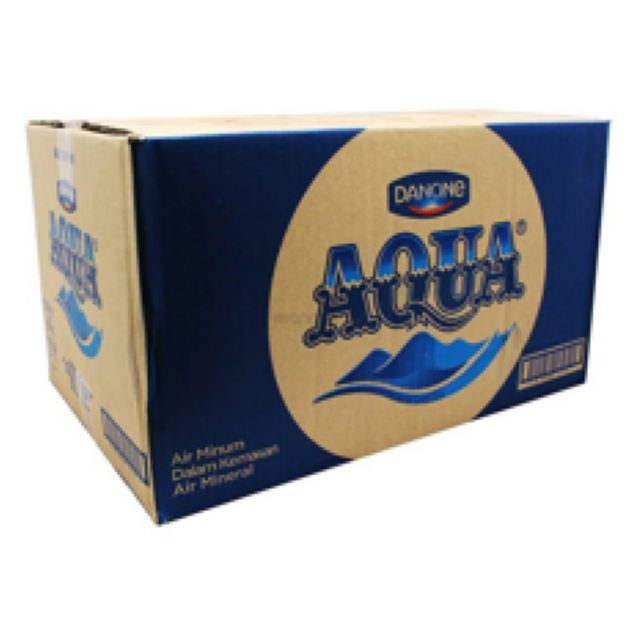

In [29]:
IMAGE_PATH = "/content/kardus_106.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/be00bca5-c05b-4517-85cd-9a33d9ca9230.jpg selesai di proses.
1/1 [==============================] - 0s 151ms/step
Prediksi Sampah:
 1. ban             : 0.784
 2. kaleng          : 0.208
 3. galon           : 0.006
 4. kaca            : 0.001
 5. botol_plastik   : 0.001
 6. kertas          : 0.000
 7. kardus          : 0.000
 8. cup_gelas       : 0.000
 9. sampah_organik  : 0.000
10. bungkus_plastik : 0.000



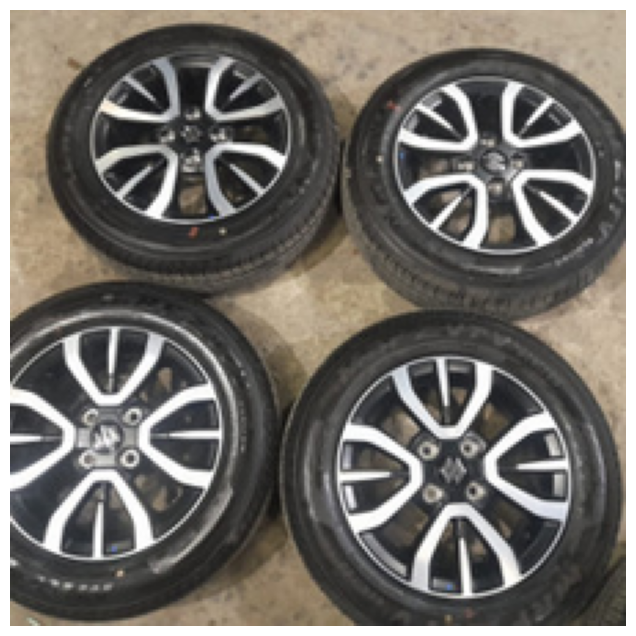

In [31]:
IMAGE_PATH = "/content/be00bca5-c05b-4517-85cd-9a33d9ca9230.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/185e1ecb613f2c99b67d4e8f74f0e7f6.jpg selesai di proses.
1/1 [==============================] - 0s 166ms/step
Prediksi Sampah:
 1. cup_gelas       : 1.000
 2. sampah_organik  : 0.000
 3. kaleng          : 0.000
 4. kardus          : 0.000
 5. bungkus_plastik : 0.000
 6. kertas          : 0.000
 7. ban             : 0.000
 8. kaca            : 0.000
 9. botol_plastik   : 0.000
10. galon           : 0.000



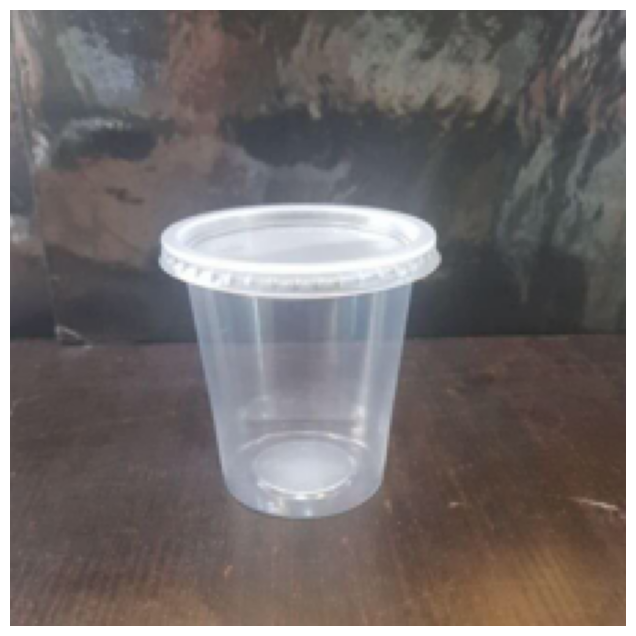

In [32]:
IMAGE_PATH = "/content/185e1ecb613f2c99b67d4e8f74f0e7f6.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/no-brand_gelas-cup-pop-ice-cup-jus-buah-cup-gelas-jualan-es-uk-12-14-16_full01.jpg selesai di proses.
1/1 [==============================] - 0s 155ms/step
Prediksi Sampah:
 1. cup_gelas       : 0.993
 2. kaleng          : 0.006
 3. sampah_organik  : 0.000
 4. bungkus_plastik : 0.000
 5. kaca            : 0.000
 6. kardus          : 0.000
 7. kertas          : 0.000
 8. ban             : 0.000
 9. botol_plastik   : 0.000
10. galon           : 0.000



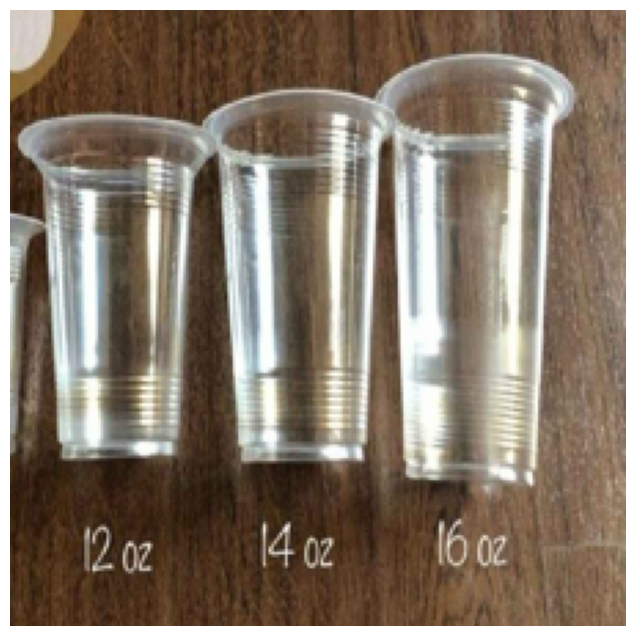

In [33]:
IMAGE_PATH = "/content/no-brand_gelas-cup-pop-ice-cup-jus-buah-cup-gelas-jualan-es-uk-12-14-16_full01.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/4805fa9a6d9e10e270f8901e22ac5ce4.jpg selesai di proses.
1/1 [==============================] - 0s 152ms/step
Prediksi Sampah:
 1. botol_plastik   : 1.000
 2. bungkus_plastik : 0.000
 3. galon           : 0.000
 4. sampah_organik  : 0.000
 5. ban             : 0.000
 6. kardus          : 0.000
 7. kaleng          : 0.000
 8. kaca            : 0.000
 9. kertas          : 0.000
10. cup_gelas       : 0.000



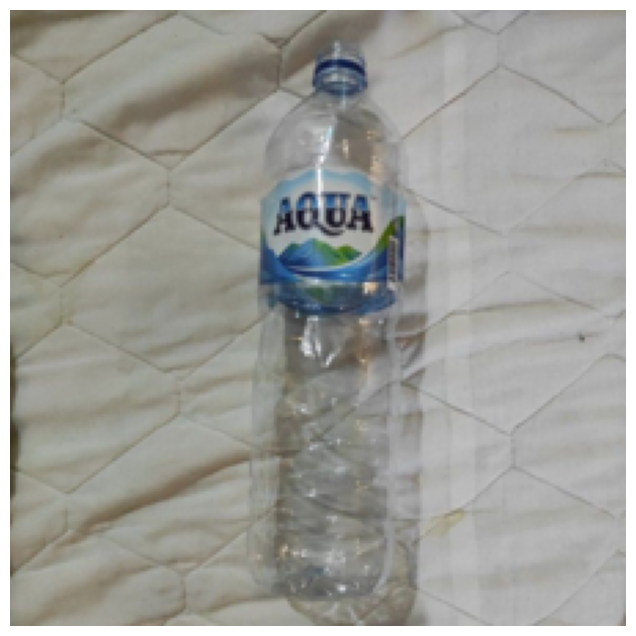

In [34]:
IMAGE_PATH = "/content/4805fa9a6d9e10e270f8901e22ac5ce4.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/kulit-pisang.jpg selesai di proses.
1/1 [==============================] - 0s 152ms/step
Prediksi Sampah:
 1. sampah_organik  : 1.000
 2. kertas          : 0.000
 3. bungkus_plastik : 0.000
 4. ban             : 0.000
 5. cup_gelas       : 0.000
 6. botol_plastik   : 0.000
 7. kardus          : 0.000
 8. kaleng          : 0.000
 9. galon           : 0.000
10. kaca            : 0.000



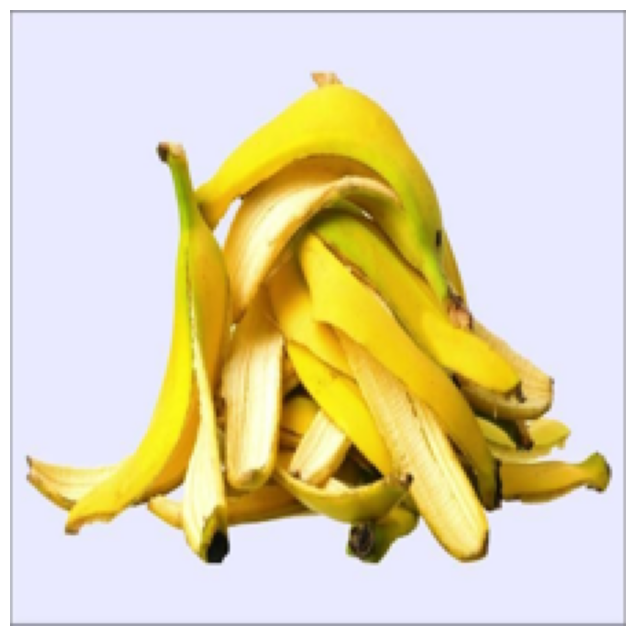

In [35]:
IMAGE_PATH = "/content/kulit-pisang.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/depositphotos_118533006-stock-photo-coca-colafanta-and-sprite-cans.jpg selesai di proses.
1/1 [==============================] - 0s 403ms/step
Prediksi Sampah:
 1. kaleng          : 1.000
 2. cup_gelas       : 0.000
 3. botol_plastik   : 0.000
 4. kaca            : 0.000
 5. kertas          : 0.000
 6. bungkus_plastik : 0.000
 7. sampah_organik  : 0.000
 8. galon           : 0.000
 9. kardus          : 0.000
10. ban             : 0.000



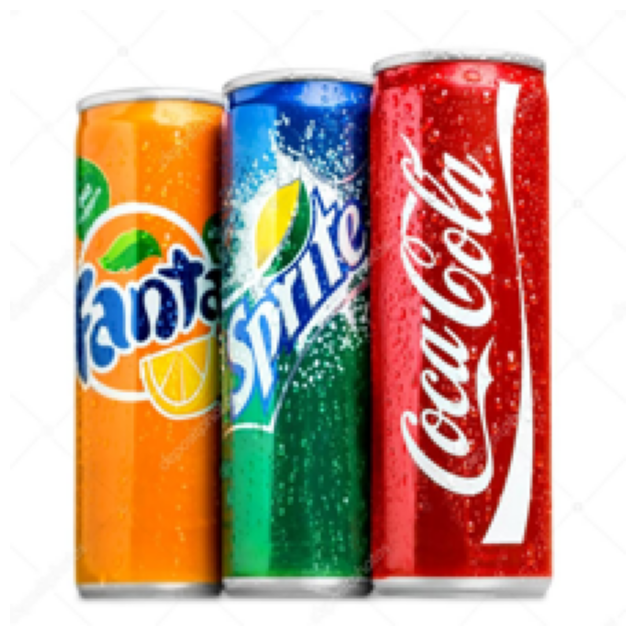

In [36]:
IMAGE_PATH = "/content/depositphotos_118533006-stock-photo-coca-colafanta-and-sprite-cans.jpg"
preprocess_and_predict(IMAGE_PATH)

Gambar /content/WhatsApp Image 2024-06-01 at 16.24.08.jpeg selesai di proses.
1/1 [==============================] - 0s 264ms/step
Prediksi Sampah:
 1. bungkus_plastik : 1.000
 2. kaleng          : 0.000
 3. ban             : 0.000
 4. sampah_organik  : 0.000
 5. botol_plastik   : 0.000
 6. cup_gelas       : 0.000
 7. kertas          : 0.000
 8. kardus          : 0.000
 9. kaca            : 0.000
10. galon           : 0.000



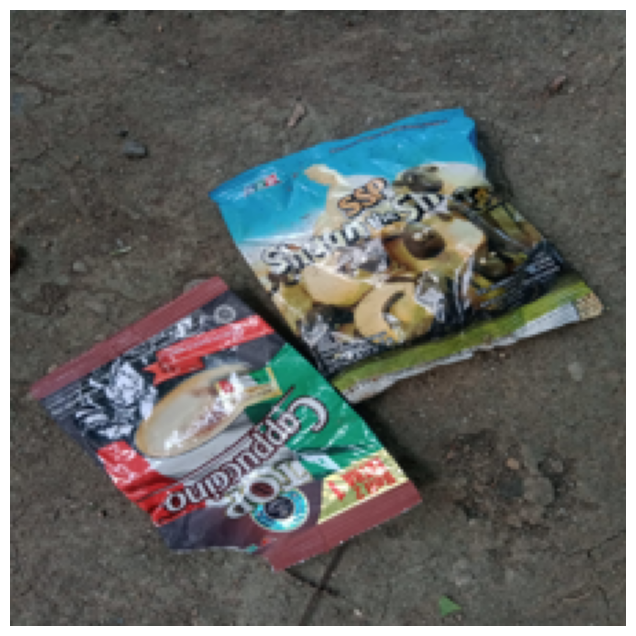

In [37]:
IMAGE_PATH = "/content/WhatsApp Image 2024-06-01 at 16.24.08.jpeg"
preprocess_and_predict(IMAGE_PATH)

# Deploy the model to h5 file

In [20]:
from keras.models import load_model
model.save('/content/drive/MyDrive/ML Team/modelDenseNet121(2).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Convert the model to TFlite

In [21]:
tflite_model = tf.keras.models.load_model("/content/drive/MyDrive/ML Team/modelDenseNet121(2).h5")
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_save = converter.convert()
open("/content/drive/MyDrive/ML Team/modelDenseNet121(2).tflite", "wb").write(tflite_save)

7966840

# TESTING H5 MODEL

In [22]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/ML Team/modelDenseNet121(2).h5')

In [40]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_dir = '/content/drive/MyDrive/ML Team/dataset_testing'

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1031 images belonging to 10 classes.


33/33 [==============================] - 157s 5s/step
                 precision    recall  f1-score   support

            ban       1.00      0.98      0.99       100
  botol_plastik       0.91      0.83      0.87       103
bungkus_plastik       0.91      0.93      0.92       102
      cup_gelas       0.95      0.97      0.96       103
          galon       0.83      0.98      0.90        98
           kaca       0.90      0.86      0.88       100
         kaleng       0.98      0.89      0.93       107
         kardus       0.99      0.92      0.95       106
         kertas       0.89      0.92      0.90       102
 sampah_organik       0.95      1.00      0.97       110

       accuracy                           0.93      1031
      macro avg       0.93      0.93      0.93      1031
   weighted avg       0.93      0.93      0.93      1031



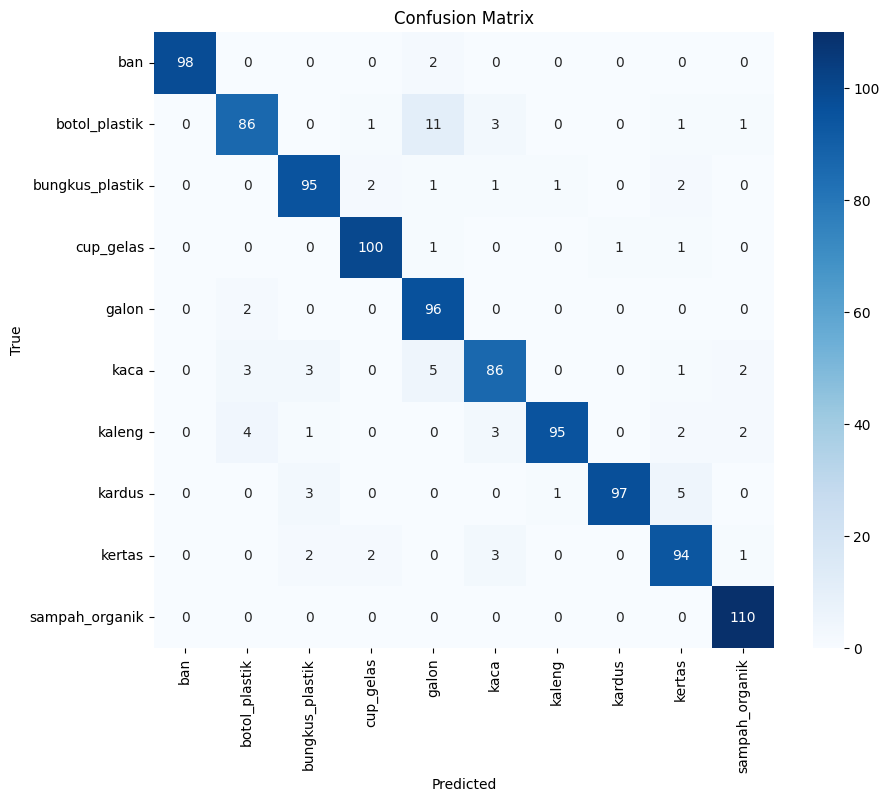

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def generate_classification_report_and_confusion_matrix(generator, model):
    # Mendapatkan label sebenarnya
    y_true = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Mendapatkan prediksi dari model
    Y_pred = model.predict(generator)
    y_pred = np.argmax(Y_pred, axis=1)

    # Menghasilkan classification report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print(report)

    # Menghasilkan confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Visualisasi confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Menggunakan fungsi ini untuk menghasilkan classification report dan confusion matrix
generate_classification_report_and_confusion_matrix(test_generator, model)


1/1 [==============================] - 6s 6s/step


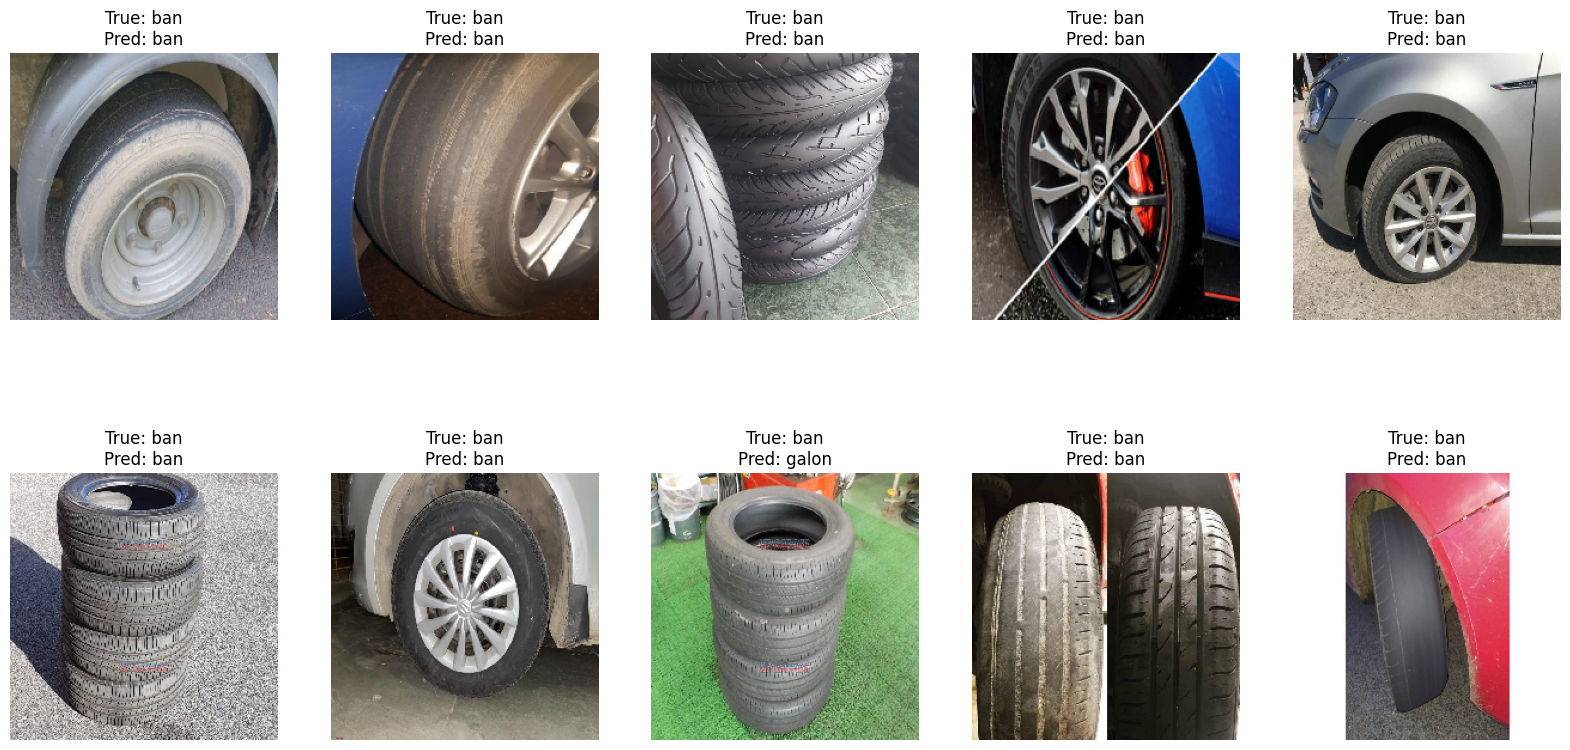

In [42]:
def plot_images_with_predictions(generator, model, class_labels, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)

    plt.figure(figsize=(20, 10))

    for i in range(min(len(images), num_images)):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i])
        true_label = class_labels[np.argmax(labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis("off")

    plt.show()

class_labels = list(test_generator.class_indices.keys())

plot_images_with_predictions(test_generator, model, class_labels, num_images=10)


In [43]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


33/33 [==============================] - 155s 5s/step - loss: 0.3163 - accuracy: 0.9282
Test Accuracy: 92.82%
